In [1]:
import pickle
from scipy.stats.mstats import gmean
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import xgboost as xgb
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [2]:
df1 = pd.read_stata(fpath + "/full_data_truncated_no_term_specific.dta")
df2 = pd.read_stata(fpath + "/full_data_truncated.dta").loc[:,['vccsid'] + [t1+"_"+t2+str(t3) for t1 in ["available", "enrolled", "term_gpa", "prop_comp", "term_cred_att", 'pell_0', 'pell_1'] for t2 in ["fa", "sp", "su"] for t3 in range(1,7,1)]]
df = df1.merge(df2, on=['vccsid'], how='inner')

In [3]:
for p in ["grants", "sub_loans", 'unsub_loans', 'others']:
    df.loc[:,p] = 0
    for s in ['yr1','yr2','yr3','yr4','yr5','yr6']:
        df.loc[:,p] += df.loc[:,p+"_"+s]
    df.loc[:,p] = df[p]/(df.pct_vccs * df.available)

In [4]:
df = df.drop(['available', 'pct_vccs'], axis=1)

In [5]:
train_df = df[df.valid == 0]
test_df = df[df.valid == 1]
print(train_df.shape,test_df.shape)

(298139, 219) (33115, 219)


##### **Note: The predictors included in this model variant are all non-term-specific predictors plus the simple term-specific predictors

In [6]:
predictors = [p for p in list(df.columns)[10:] if p[-3:] not in ['yr1','yr2','yr3','yr4','yr5','yr6']]
print(len(predictors))
impute_list_1 = set(["prop_comp_pre","cum_gpa_pre"])
impute_list_2 = set([t1+"_"+t2+str(t3) for t1 in ["term_gpa", "prop_comp", "term_cred_att"] for t2 in ["fa", "sp", "su"] for t3 in range(1,7,1)])
impute_list_3 = set(["cum_gpa", "lvl2_prop_comp", "dev_prop_comp", "prop_comp", "prop_comp_sd", "withdrawn_prop_comp_sd"])
impute_list_4 = set(["admrate", "gradrate", "satvr25", "satvr75", "satmt25", "satmt75", "satwr25", "satwr75"])

185


In [7]:
def impute(train, test):
    for p in impute_list_1:
        avg_p = np.nanmean(train[train.enrolled_pre == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_2:
        suffix = p[-3:]
        avg_p = np.nanmean(train[train["enrolled_" + suffix] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_4:
        avg_p = np.nanmean(train[train["enrolled_nsc"] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test      

In [8]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [10]:
np.random.seed(4321)
val_indices = np.random.choice(train_df.shape[0], int(np.floor(train_df.shape[0]*0.15)), replace=False)
train_val = train_df.iloc[val_indices,:]
train_train = train_df.iloc[np.setdiff1d(np.arange(train_df.shape[0]), val_indices),:]
train_train_new, train_val_new = impute(train_train, train_val)
X_train_train = train_train_new.loc[:,predictors]
y_train_train = train_train_new.grad_6years
X_train_val = train_val_new.loc[:,predictors]
y_train_val = train_val_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
dtrain_train = xgb.DMatrix(X_train_train, y_train_train)
dtrain_val = xgb.DMatrix(X_train_val, y_train_val)

In [12]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_simple_predictors\\"

#### (1) Grid Search for max_depth and eta (learning rate)

In [45]:
grid_1 = [(md,e) for md in range(4,8) for e in [0.01, 0.02, 0.05, 0.1, 0.2]]
validation_auc_1 = Counter()
for md,e in grid_1:
    print("max_depth = {0}, eta = {1}:".format(md,e))
    params = {'max_depth': md, 'eta': e, 'min_child_weight': 1, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_1[(md,e)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 4, eta = 0.01:
[0]	validation-auc:0.81863
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.849719
[100]	validation-auc:0.855236
[150]	validation-auc:0.860501
[200]	validation-auc:0.864632
[250]	validation-auc:0.867923
[300]	validation-auc:0.870687
[350]	validation-auc:0.872948
[400]	validation-auc:0.874888
[450]	validation-auc:0.876424
[500]	validation-auc:0.877781
[550]	validation-auc:0.878885
[600]	validation-auc:0.879934
[650]	validation-auc:0.880841
[700]	validation-auc:0.88163
[750]	validation-auc:0.882357
[800]	validation-auc:0.883026
[850]	validation-auc:0.883662
[900]	validation-auc:0.884242
[950]	validation-auc:0.884741
[1000]	validation-auc:0.885214
[1050]	validation-auc:0.885683
[1100]	validation-auc:0.886095
[1150]	validation-auc:0.88647
[1200]	validation-auc:0.88688
[1250]	validation-auc:0.887172
[1300]	validation-auc:0.887498
[1350]	validation-auc:0.887834
[1400]	validation-auc:0.888125
[1450]	validation-auc:0.888421
[1500]	v

[2200]	validation-auc:0.894464
[2250]	validation-auc:0.894572
[2300]	validation-auc:0.89469
[2350]	validation-auc:0.894785
[2400]	validation-auc:0.894858
[2450]	validation-auc:0.894965
[2500]	validation-auc:0.89504
[2550]	validation-auc:0.895123
[2600]	validation-auc:0.895192
[2650]	validation-auc:0.895288
[2700]	validation-auc:0.895355
[2750]	validation-auc:0.895432
[2800]	validation-auc:0.895496
[2850]	validation-auc:0.895568
[2900]	validation-auc:0.895643
[2950]	validation-auc:0.895697
[3000]	validation-auc:0.895771
[3050]	validation-auc:0.895849
[3100]	validation-auc:0.895899
[3150]	validation-auc:0.895965
Stopping. Best iteration:
[3184]	validation-auc:0.896011


max_depth = 5, eta = 0.02:
[0]	validation-auc:0.831366
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.863327
[100]	validation-auc:0.870972
[150]	validation-auc:0.876044
[200]	validation-auc:0.879578
[250]	validation-auc:0.882191
[300]	validation-auc:0.884287
[350]	validation-auc:0.8859

[750]	validation-auc:0.892143
[800]	validation-auc:0.892668
[850]	validation-auc:0.893078
[900]	validation-auc:0.893438
[950]	validation-auc:0.893816
[1000]	validation-auc:0.894144
[1050]	validation-auc:0.89444
[1100]	validation-auc:0.894745
[1150]	validation-auc:0.894978
[1200]	validation-auc:0.895214
[1250]	validation-auc:0.895414
[1300]	validation-auc:0.895619
[1350]	validation-auc:0.895839
[1400]	validation-auc:0.895976
[1450]	validation-auc:0.896159
[1500]	validation-auc:0.896317
[1550]	validation-auc:0.896445
[1600]	validation-auc:0.896585
[1650]	validation-auc:0.896671
[1700]	validation-auc:0.896786
[1750]	validation-auc:0.896874
[1800]	validation-auc:0.896984
[1850]	validation-auc:0.897068
[1900]	validation-auc:0.897167
[1950]	validation-auc:0.897267
[2000]	validation-auc:0.89736
[2050]	validation-auc:0.897448
[2100]	validation-auc:0.897507
[2150]	validation-auc:0.897593
[2200]	validation-auc:0.897653
[2250]	validation-auc:0.897718
[2300]	validation-auc:0.897792
[2350]	validati

In [46]:
for t in validation_auc_1.most_common():
    print(t)

((7, 0.01), 0.898354)
((7, 0.05), 0.897967)
((7, 0.02), 0.897813)
((6, 0.05), 0.897735)
((6, 0.01), 0.897334)
((6, 0.02), 0.897131)
((5, 0.05), 0.896955)
((6, 0.1), 0.896607)
((5, 0.02), 0.896415)
((7, 0.1), 0.896407)
((5, 0.1), 0.896357)
((4, 0.1), 0.896129)
((5, 0.01), 0.896011)
((6, 0.2), 0.895673)
((4, 0.02), 0.89564)
((4, 0.05), 0.895503)
((4, 0.01), 0.895441)
((5, 0.2), 0.894992)
((4, 0.2), 0.894722)
((7, 0.2), 0.894603)


#### (2) Grid Search for min_child_weight (along with max_depth)

In [47]:
md1 = 6
grid_2 = [(md1+i,mcw) for i in [-1,0,1] for mcw in [3,5]]
validation_auc_2 = Counter()
for md,mcw in grid_2:
    print("max_depth = {0}, min_child_weight = {1}:".format(md,mcw))
    params = {'max_depth': md, 'eta': 0.05, 'min_child_weight': mcw, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_2[(md,mcw)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 5, min_child_weight = 3:
[0]	validation-auc:0.831366
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.873753
[100]	validation-auc:0.882363
[150]	validation-auc:0.886488
[200]	validation-auc:0.889114
[250]	validation-auc:0.890881
[300]	validation-auc:0.892188
[350]	validation-auc:0.893209
[400]	validation-auc:0.893889
[450]	validation-auc:0.894515
[500]	validation-auc:0.894907
[550]	validation-auc:0.895323
[600]	validation-auc:0.895624
[650]	validation-auc:0.895964
[700]	validation-auc:0.896204
[750]	validation-auc:0.896434
[800]	validation-auc:0.896649
[850]	validation-auc:0.896798
Stopping. Best iteration:
[888]	validation-auc:0.896952


max_depth = 5, min_child_weight = 5:
[0]	validation-auc:0.831366
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.873823
[100]	validation-auc:0.882134
[150]	validation-auc:0.886459
[200]	validation-auc:0.889002
[250]	validation-auc:0.890626
[300]	validation-auc:0.891975


In [48]:
for t in validation_auc_2.most_common():
    print(t)

((6, 5), 0.897839)
((7, 3), 0.897758)
((7, 5), 0.897757)
((6, 3), 0.897659)
((5, 3), 0.896952)
((5, 5), 0.896892)


#### (3) Grid Search for colsample_by_tree

In [49]:
grid_3 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
validation_auc_3 = Counter()
for cbt in grid_3:
    print("colsample_by_tree = {}:".format(cbt))
    params = {'max_depth': 6, 'eta': 0.05, 'min_child_weight': 5, 'colsample_bytree': cbt, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_3[cbt] = np.max(evals_result['validation']['auc'])
    print("")

colsample_by_tree = 0.5:
[0]	validation-auc:0.833983
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.878128
[100]	validation-auc:0.885266
[150]	validation-auc:0.889409
[200]	validation-auc:0.891502
[250]	validation-auc:0.892961
[300]	validation-auc:0.893966
[350]	validation-auc:0.894813
[400]	validation-auc:0.89536
[450]	validation-auc:0.895889
[500]	validation-auc:0.896247
[550]	validation-auc:0.896548
[600]	validation-auc:0.896774
[650]	validation-auc:0.896986
Stopping. Best iteration:
[662]	validation-auc:0.897066


colsample_by_tree = 0.55:
[0]	validation-auc:0.841531
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.878349
[100]	validation-auc:0.885455
[150]	validation-auc:0.88956
[200]	validation-auc:0.891635
[250]	validation-auc:0.893206
[300]	validation-auc:0.894101
[350]	validation-auc:0.894972
[400]	validation-auc:0.895534
[450]	validation-auc:0.896027
[500]	validation-auc:0.896374
[550]	validation-auc:0.89

In [50]:
validation_auc_3.most_common()

[(0.85, 0.897878),
 (0.65, 0.89786),
 (0.9, 0.897857),
 (0.8, 0.897839),
 (0.75, 0.897652),
 (0.6, 0.897613),
 (0.55, 0.897601),
 (0.7, 0.897468),
 (0.5, 0.897066)]

#### (4) Finally select the opitmal num_boost_round

In [51]:
params = {'max_depth': 6, 'eta': 0.05, 'min_child_weight': 5, 'colsample_bytree': 0.85, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
evals_result = {}
xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                      early_stopping_rounds = 10,
                      evals_result = evals_result,
                      verbose_eval = 50)
optimal_num_boost_round = np.argmax(evals_result['validation']['auc'])
print("")
print(optimal_num_boost_round)

[0]	validation-auc:0.842543
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.877811
[100]	validation-auc:0.885768
[150]	validation-auc:0.889722
[200]	validation-auc:0.891831
[250]	validation-auc:0.893451
[300]	validation-auc:0.894435
[350]	validation-auc:0.895164
[400]	validation-auc:0.895816
[450]	validation-auc:0.896364
[500]	validation-auc:0.896668
[550]	validation-auc:0.896943
[600]	validation-auc:0.897122
[650]	validation-auc:0.897356
[700]	validation-auc:0.897579
[750]	validation-auc:0.897669
[800]	validation-auc:0.897865
Stopping. Best iteration:
[812]	validation-auc:0.897878


812


#### (5) Train the final xgb model and make predictions for observations in the test set

In [13]:
optimal_num_boost_round = 812

In [14]:
# specify parameters via map
params = {'max_depth': 6, 'eta': 0.05, 'min_child_weight': 5, 'colsample_bytree': 0.85, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
final_xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = optimal_num_boost_round)
# make prediction for observations in the test set
y_test_pred = final_xgb_model.predict(dtest)

In [15]:
print("XGBoost:")
print("AUC = {}".format(round(roc_auc_score(dtest.get_label(), y_test_pred), 4)))

XGBoost:
AUC = 0.9024


In [16]:
# save the model object and predicted scores on the validation sample to local disk
pickle.dump(final_xgb_model, open(results_dir + "/xgb.p", "wb"))
pickle.dump(list(y_test_pred), open(results_dir + "/y_test_pred_xgb.p", "wb"))

In [17]:
feature_importance = pd.DataFrame(list(final_xgb_model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance.loc[:, 'importance'] = feature_importance.loc[:, 'importance'] / sum(feature_importance.loc[:, 'importance'])
yy = feature_importance.loc[:, 'importance'].iloc[:20]
xx = feature_importance.loc[:, 'feature'].iloc[:20]

In [18]:
xgb_summary = feature_importance.rename(columns = {'feature':'predictor_name',
                                                   'importance':'feature_importance'})\
.loc[:,['predictor_name', 'feature_importance']]
xgb_summary = xgb_summary.merge(pd.DataFrame({'predictor_name': predictors}), on=['predictor_name'], how='right')\
.sort_values(['feature_importance', 'predictor_name'], ascending=[False, True]).fillna(0)
xgb_summary.to_csv(results_dir + "xgb_summary.csv", index=False)

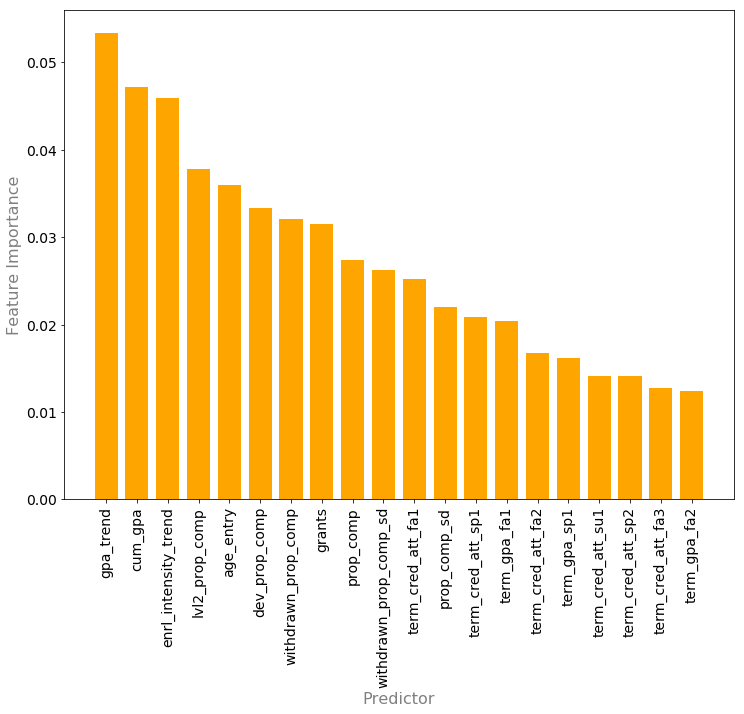

In [19]:
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(20)), yy, width=0.75, color = "orange")
plt.xticks(list(range(20)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16, color="gray")
plt.ylabel("Feature Importance", fontsize=16, color="gray")
plt.savefig(results_dir + "XGBoost_variable_importance.png")
plt.show()

In [20]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, xgb_params, nbr):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        dtrain_cv = xgb.DMatrix(X_1,y_1)
        dtest_cv = xgb.DMatrix(X_2,y_2)
        xgb_cv_model = xgb.train(params=xgb_params, dtrain=dtrain_cv, num_boost_round = nbr)
        y_2_pred = xgb_cv_model.predict(dtest_cv)
        p,r,t = precision_recall_curve(y_2, y_2_pred)
        auc = roc_auc_score(y_2, y_2_pred)
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)

In [21]:
final_params = {'max_depth': 6, 'eta': 0.05, 'min_child_weight': 5, 'colsample_bytree': 0.85, 
                'subsample': 0.8, 
                'objective': 'binary:logistic', 'eval_metric': ['auc'],
                'seed': 12345}
best_threshold = cross_validation(train_df, final_params, optimal_num_boost_round)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0.8997617524465416 0.001852054428182501


In [22]:
best_threshold

0.42022112

In [23]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [24]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_xgb = create_confusion_matrix(y_test_pred, best_threshold, "XGBoost_cm1")

F1 threshold = 0.42:

         Pred_0   Pred_1         
Real_0  19069.0   2739.0  21808.0
Real_1   2530.0   8777.0  11307.0
        21599.0  11516.0  33115.0

F1 score = 0.7691


In [25]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_xgb = create_confusion_matrix(y_test_pred_binary, best_threshold, "XGBoost_cm2")

Alternative threshold = 0.434:

         Pred_0   Pred_1         
Real_0  19177.0   2631.0  21808.0
Real_1   2612.0   8695.0  11307.0
        21789.0  11326.0  33115.0

F1 score = 0.7683


In [26]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_xgb,(alternative_threshold,)+pr2_xgb]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "XGBoost_precision_recall.csv", index=True)

#### Reorganize files of key evaluation metrics for the five models: OLS, Logit, RF, XGBoost and CoxPH

In [33]:
# Extract all of the key evaluation metrics of the five models that exclude demographic predictors,
# which will be used to create Figure A8 and Figure 2 of the paper
cstat = [0.8816,0.8773,0.8794,0.8892,0.9024]
m_dict = {'Logit': 'LR1', 'OLS': 'OLS',
          'RF': 'RF', 'XGBoost': 'XGBoost',
          'CoxPH': 'Cox'}
m_list = ['Logit', 'OLS', 'CoxPH', 'RF', 'XGBoost']
summary = []
for c,m in zip(cstat,m_list):
    summary.append((m,c)+tuple(pd.read_csv(results_dir + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
summary_df = pd.DataFrame(summary, columns=['model','c-statistic','threshold','precision_1','recall_1',
                                            'precision_0','recall_0','f1_score_1'])
summary_df.loc[:,'f1_score_0'] = 2*summary_df.precision_0*summary_df.recall_0/(summary_df.precision_0+summary_df.recall_0)
summary_df.loc[:,'f1_score_0'] = summary_df.loc[:,'f1_score_0'].apply(lambda x: round(x,4))
summary_df.round(4).to_csv(results_dir + "cleaned_results\\main_eval_metrics.csv", index=False)